In [99]:
import torch
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torchmetrics as tmetrics
import torch.nn.functional as F
import time
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset , Subset, random_split
from PIL import Image
from src import utils
from torch.cuda.amp import GradScaler, autocast

torch.manual_seed(42)
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# autoreload
%load_ext autoreload
%autoreload 2

In [4]:
image_path = os.listdir(os.path.join('archive', 'Image'))
mask_path = os.listdir(os.path.join('archive', 'Mask'))
len(image_path), len(mask_path)
np.random.seed(42)
train_indices = np.random.choice(len(image_path), size=int(0.8*len(image_path)), replace=False)
test_indices = np.array(list(set(range(len(image_path))) - set(train_indices)))

In [8]:
train_image_path = np.take(image_path, train_indices)
train_mask_path = np.take(mask_path, train_indices)
test_image_path = np.take(image_path, test_indices)
test_mask_path = np.take(mask_path, test_indices)


In [59]:
train_image = [Image.open(os.path.join('archive', 'Image', i)) for i in train_image_path]
train_mask = [Image.open(os.path.join('archive', 'Mask', i)) for i in train_mask_path]
test_image = [Image.open(os.path.join('archive', 'Image', i)) for i in test_image_path]
test_mask = [Image.open(os.path.join('archive', 'Mask', i)) for i in test_mask_path]

In [60]:
for i in range(len(train_image)):
    train_image[i] = train_image[i].convert('RGB')
    train_mask[i] = train_mask[i]
for i in range(len(test_image)):
    test_image[i] = test_image[i].convert('RGB')
    test_mask[i] = test_mask[i]

In [61]:
# Transformations

Transforms = A.Compose([
    A.Resize(224,224),
    A.HorizontalFlip(p=0.75),
    A.VerticalFlip(p=0.75),
    # A.GridDistortion(p=0.75),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    # A.PixelDropout(dropout_prob=0.5),
    # A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, p=0.5),
    ToTensorV2(),
])

base = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])


In [67]:
class CustomFloodDataset(Dataset):
    """
    Custom dataset for flood segmentation

    Parameters
    ----------
    Dataset : torch.utils.data.Dataset
        Dataset class from torch.utils.data
    """
    def __init__(self, image_list, mask_list, transform=None):
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform

    def __getitem__(self, idx):
        image = self.image_list[idx]
        mask = self.mask_list[idx]
        image = np.array(image)
        mask = np.array(mask)
        
        # mask = np.reshape(mask, mask.shape + (1,))
        if self.transform:
            augment = self.transform(image=image, mask=mask)
            image = augment['image']
            mask = augment['mask'] / 255
        return image, mask
    
    def __len__(self):
        return len(self.image_list)

In [68]:
train_dataset = CustomFloodDataset(train_image, train_mask, transform=Transforms)
test_dataset = CustomFloodDataset(test_image, test_mask, transform=base)

In [69]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [139]:
from model import unet
from vgg19 import VGGUNet
vgg = VGGUNet(num_classes=1).to(device)
Unet = vgg

In [140]:
optimizer = torch.optim.Adam(Unet.parameters(), lr=0.00001)
criterion = nn.BCEWithLogitsLoss()
es = utils.EarlyStopper(patience=50, verbose=True, model=Unet)

In [141]:
random_idx = np.random.randint(0, len(test_image))
sample_image = ToTensor()(test_image[random_idx]).unsqueeze(0).to(device)
TO_GIF = []
scaler = GradScaler()
EPOCH = 100
es = utils.EarlyStopper(patience=10, verbose=True,min_epoch=5, model = Unet)
import time
for epoch in range(EPOCH):
    train_loss = []
    Unet.train()

    # Training 
    t1 = time.time()
    for image, mask in train_dataloader:
        optimizer.zero_grad()
        with autocast():
            image = image.to(device)
            mask = mask.to(device)
            output = Unet(image).squeeze(1)
            loss = criterion(output.float(), mask.float())
        
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Validation
    Unet.eval()
    test_loss = []
    with torch.no_grad():
        for image, mask in test_dataloader:
            image = image.to(device)
            mask = mask.to(device)
            output = Unet(image).squeeze(1)
            loss = criterion(output.float(), mask.float())
            test_loss.append(loss.item())
            # trying out print
            sample_mask = Unet(sample_image_transformed)
            prob = F.sigmoid(sample_mask)
            predicted = (prob > 0.5).float()
            predicted = predicted.squeeze(0).squeeze(0).cpu().numpy()
            TO_GIF.append(predicted)
    
    t2 = time.time()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch+1} / {EPOCH}, Loss: {np.mean(train_loss)}\t"
            f"Val Loss: {np.mean(test_loss)} \t Time: {t2-t1:.2f}")
    if es.early_stop(epoch, np.mean(test_loss)):
        break
    

Epoch: 1 / 100, Loss: 0.6974953730901082	Val Loss: 0.6883242279291153 	 Time: 3.70
Epoch: 11 / 100, Loss: 0.4697532892227173	Val Loss: 0.44175082445144653 	 Time: 3.49
Epoch: 21 / 100, Loss: 0.2984918793042501	Val Loss: 0.2514340691268444 	 Time: 3.52
Epoch: 31 / 100, Loss: 0.26497814754645027	Val Loss: 0.22344007343053818 	 Time: 3.49
Epoch: 41 / 100, Loss: 0.2400805284579595	Val Loss: 0.215500820428133 	 Time: 3.47
Epoch: 51 / 100, Loss: 0.22962590157985688	Val Loss: 0.2121022567152977 	 Time: 3.48
Early Stopping


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


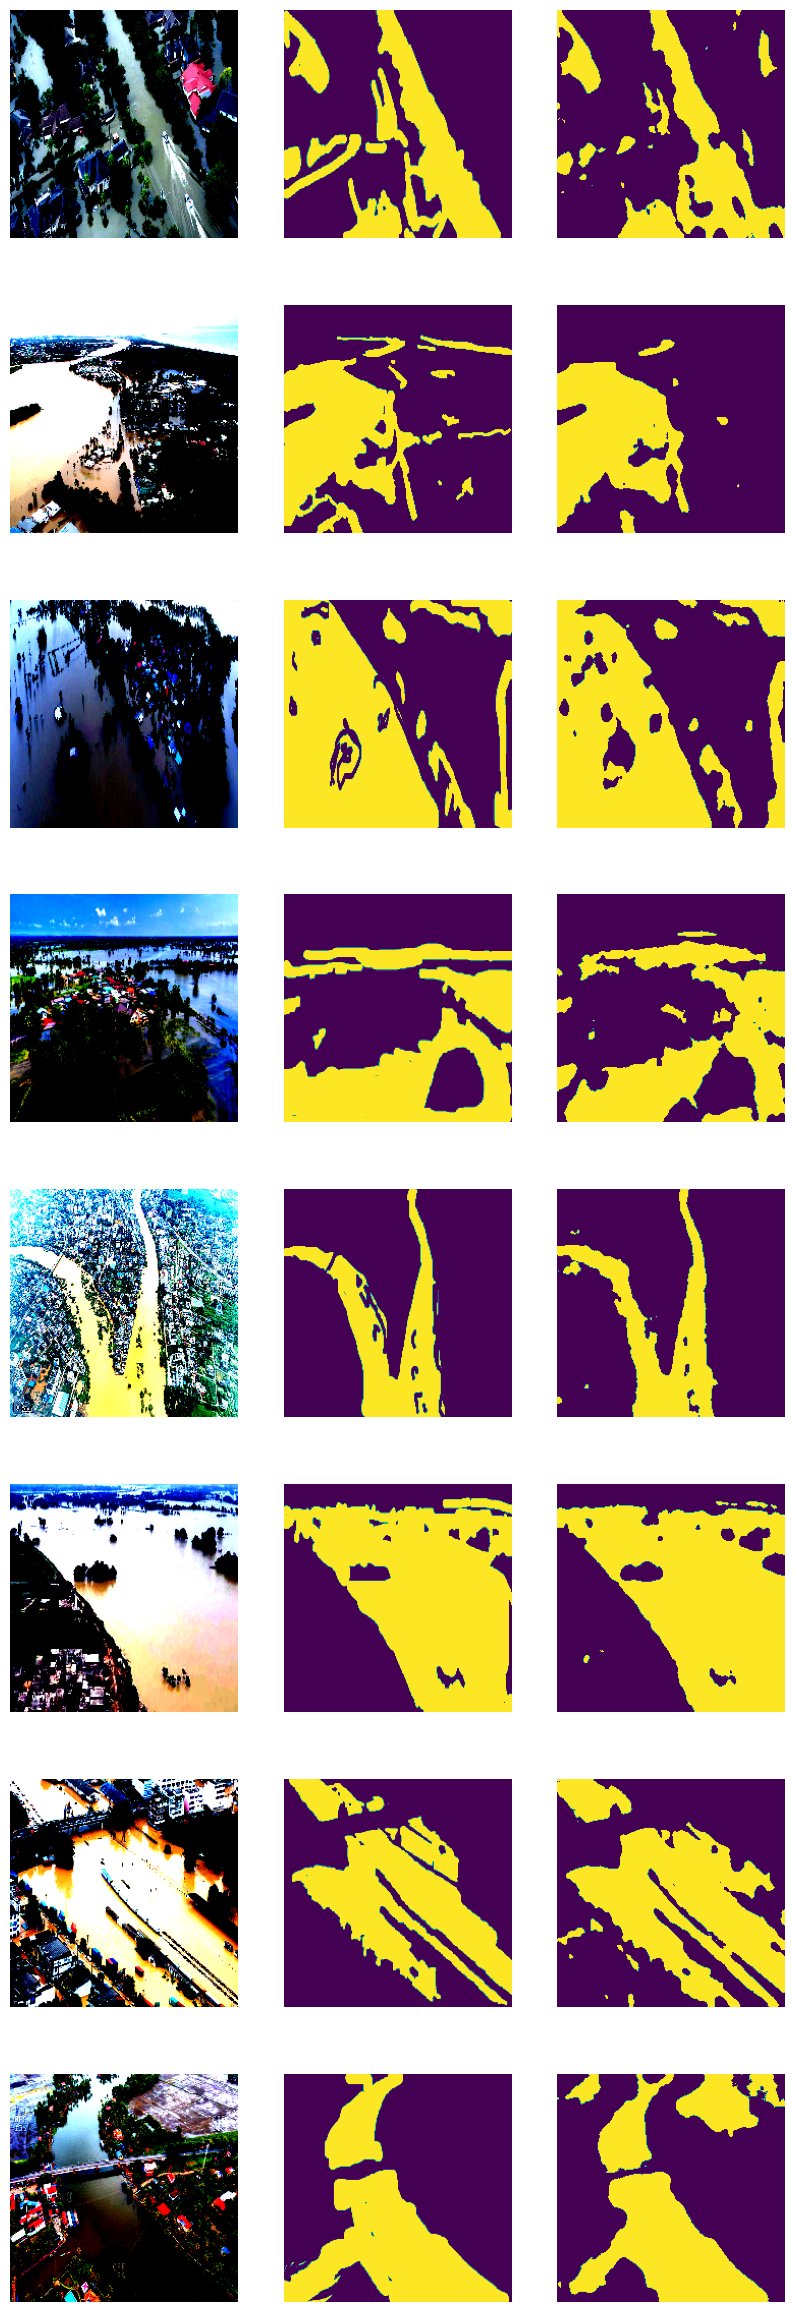

In [142]:
fig, ax = plt.subplots(8,3,figsize=(10,30))
Unet.eval()
test_mask = Unet(image.to(device))
prob = F.sigmoid(test_mask)
predicted = (prob > 0.5).float()
with torch.no_grad():
    for i in range(8):
        ax[i,0].imshow(image[i].cpu().permute(1,2,0))
        ax[i,0].axis('off')
        ax[i,1].imshow(mask[i].squeeze(0).cpu().numpy())
        ax[i,1].axis('off')
        ax[i,2].imshow(predicted.cpu().detach().numpy()[i].squeeze(0))
        ax[i,2].axis('off')

In [150]:
import imageio

imageio.mimsave('test.gif', TO_GIF, fps=5)